# 1. Data Preprocessing

In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP

In [2]:
# Create Data

x = np.linspace(0, 300, 3000)
y1 = 0.1*np.sin(x)
y2 = y1 + 0.1*np.sin(x*1.1+10)
y3 = 0.005*np.sin(x*2)+0.005*np.sin(x*3+10)+0.005*np.sin(x*5+1)
y4 = y3-0.01

data = np.array([y1,y2,y3,y4]).T

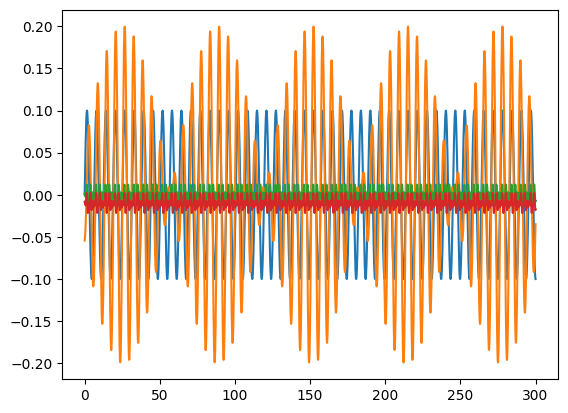

In [3]:
import matplotlib.pylab as plt
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4)


In [4]:
timesteps,features = data.shape

train = data[:int(timesteps*.8)]

In [5]:
train = torch.FloatTensor(train)

In [2]:
# Import data

def import_train_data(dir):
    df = None
    min_cols,max_cols = (None,None)
    for file in os.listdir(dir):
        print(f"train: {file}")
        _df = pd.read_csv(f"{os.path.join(dir,file)}", sep="\t", header=None)
        _df = _df.drop(columns=[0])
        if df is None:
            df = _df
        else:
            df = pd.concat([df,_df])

    min_cols = df.min()
    max_cols = df.max()
    df = (df-df.min())/(df.max()-df.min())
        
    return df, min_cols, max_cols

def import_test_data(dir, min_cols, max_cols):
    dfs = []

    for file in os.listdir(dir):
        print(f"test: {file}")
        _df = pd.read_csv(f"{os.path.join(dir,file)}", sep="\t", header=None)
        _df = _df.drop(columns=[0])        
        _df = (_df-min_cols)/(max_cols-min_cols)
        dfs.append(_df)
        
    return dfs

train_df, train_min, train_max = import_train_data("/Users/faith/Desktop/Projects/tsad/data/train")
test_dfs = import_test_data("/Users/faith/Desktop/Projects/tsad/data/test", train_min, train_max)

# Convert to Tensors

dropout = 10
train = torch.FloatTensor(train_df[::dropout].values)

train: 07112001.txt
train: 06112001.txt
train: 08112001.txt
train: 05112001.txt
test: 20112001.txt
test: 30102001.txt
test: 17112001.txt
test: 09112001.txt


In [3]:
# Create Dataset Class

class TimewindowDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        
    def __len__(self):
        return self.data.shape[0]-self.window_size
    
    def __getitem__(self,i):
        return (self.data[i:i+self.window_size], self.data[i+self.window_size])
    
window_size = 20
num_sensors = train.shape[1]
train_dataset = TimewindowDataset(train, window_size)
train_dataloader = DataLoader(train_dataset, shuffle=True)

# 2. Model

In [4]:
# 1D Conv + 2 GATs + GRU + FFN

class GATModel(torch.nn.Module):
    def __init__(self, window_size, num_sensors, heads=1, kernel_size=7, hidden_dim=256, n_layers=1, concat=True):
        """
        n = nu
        mber timesteps
        k = number sensors
        """
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.num_sensors = num_sensors
        self.heads = heads
        self.conv_1d = nn.Conv1d(num_sensors, num_sensors, kernel_size)
        self.gat_f = GATConv(window_size-kernel_size+1, window_size-kernel_size+1, heads=heads)
        self.gat_t = GATConv(num_sensors, num_sensors, heads=heads)
        self.fc1 = nn.Linear((window_size-kernel_size+1)*(heads*2+1), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x = self.conv_1d(x.T).T
        x1,alpha_f = self.gat_feature(x)
        x2,alpha_t = self.gat_time(x)
        x = torch.hstack((x.T,x1))
        for head in range(self.heads):
            x = torch.hstack((x,x2[:,head*self.num_sensors:(head+1)*num_sensors].T))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        
        return x,alpha_f,alpha_t
    
    def complete_edge_idx(self,num_nodes):
        nodes = torch.tensor(list(range(num_nodes)))
        idx1 = nodes.repeat_interleave(num_nodes)
        idx2 = nodes.repeat(num_nodes)
        idx = [i for i in range(num_nodes*num_nodes) if i%(num_nodes+1)!=0]
        return torch.vstack((idx1,idx2))[:,idx]

    def gat_feature(self,x):
        edge_idx = self.complete_edge_idx(x.shape[1])
        data = Data(x=x.T, edge_index=edge_idx)
        x,alpha = self.gat_f(data.x, data.edge_index, return_attention_weights=True)
        return x,alpha      
    
    def gat_time(self,x):
        edge_idx = self.complete_edge_idx(x.shape[0])
        data = Data(x=x, edge_index=edge_idx)
        x,alpha = self.gat_t(data.x, data.edge_index, return_attention_weights=True)
        return x,alpha
    

# 3. Training

In [5]:
learn_rate=1e-4
EPOCHS = 10
model = GATModel(window_size,num_sensors,heads=3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
for epoch in range(0,EPOCHS):
    for i,item in enumerate(train_dataloader):
        window, target = item
        window = window.squeeze()
        target = target.T.squeeze()
        x,alpha_f,alpha_t = model(window)
        model.zero_grad()
        loss = None
        for sensor in range(len(target)):
            if loss is None:
                loss = criterion(x[sensor].squeeze(),target[sensor])
            else:
                loss += criterion(x[sensor].squeeze(),target[sensor])
        loss.backward()
        optimizer.step()
        if i%1000 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS}, item {i}/{len(train_dataloader)}, loss {loss.item()}")


Epoch 1/10, item 0/34540, loss 11.632911682128906
Epoch 1/10, item 1000/34540, loss 0.5938313007354736
Epoch 1/10, item 2000/34540, loss 0.29347047209739685
Epoch 1/10, item 3000/34540, loss 0.08135894685983658
Epoch 1/10, item 4000/34540, loss 0.0883675068616867
Epoch 1/10, item 5000/34540, loss 0.06169094517827034
Epoch 1/10, item 6000/34540, loss 0.07132332772016525
Epoch 1/10, item 7000/34540, loss 0.08984049409627914
Epoch 1/10, item 8000/34540, loss 0.06898459047079086
Epoch 1/10, item 9000/34540, loss 0.029697122052311897
Epoch 1/10, item 10000/34540, loss 0.1036558523774147
Epoch 1/10, item 11000/34540, loss 0.07833757251501083
Epoch 1/10, item 12000/34540, loss 0.04780282452702522
Epoch 1/10, item 13000/34540, loss 0.059060271829366684
Epoch 1/10, item 14000/34540, loss 0.07419534027576447
Epoch 1/10, item 15000/34540, loss 0.10486478358507156
Epoch 1/10, item 16000/34540, loss 0.05954898148775101
Epoch 1/10, item 17000/34540, loss 0.08855991065502167
Epoch 1/10, item 18000/34

KeyboardInterrupt: 

In [6]:
PATH = "ffn_gat_test.pt"
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

# 4. Eval

In [7]:
#test = data[int(timesteps*.8):]
#test = torch.FloatTensor(test)
#test_dataset = TimewindowDataset(test, window_size)
#test_dataloader = DataLoader(test_dataset)

In [58]:
test = torch.FloatTensor(test_dfs[3][::dropout].values)
num_timesteps = test.shape[0]
start = num_timesteps-750
test_dataset = TimewindowDataset(test[start:], window_size)
test_dataloader = DataLoader(test_dataset)

In [59]:
# Eval model without GRU
model.eval()
preds = None
targets = None
attn_f = None
attn_t = None
attn_f_edge_idx = None
attn_t_edge_idx = None

for i,item in enumerate(test_dataloader):
    #if i%100==0:
    print(f"item: {i}/{len(test_dataloader)}")
    window, target = item
    window = window.squeeze()
    target = target.T.squeeze()
    x,alpha_f,alpha_t = model(window)

    '''if i%100 == 0:
        for attn_head in range(alpha_f[1].shape[1]):
            alpha_f_matrix = np.zeros((num_sensors,num_sensors))
            edges = alpha_f[0]
            weights = alpha_f[1][:,attn_head]
            #print(edges)
            #print(weights)
            for idx in range(len(edges[0])):
                i,j = edges[0][idx],edges[1][idx]
                alpha_f_matrix[i][j] = weights[idx]
            print("Alpha Spatial")
            print(alpha_f_matrix)
        for attn_head in range(alpha_t[1].shape[1]):
            max_timestep = alpha_t[0][0].max()+1
            alpha_t_matrix = np.zeros((max_timestep,max_timestep))
            edges = alpha_t[0]
            weights = alpha_t[1][:,attn_head]
            #print(edges)
            #print(weights)
            for idx in range(len(edges[0])):
                i,j = edges[0][idx],edges[1][idx]
                alpha_t_matrix[i][j] = weights[idx]
            print("Alpha Temporal")
            print(alpha_t_matrix)'''
            
    # Save prediction
    if preds is None:
        preds = x.detach().numpy().reshape(-1)
    else:
        preds = np.vstack((preds,x.detach().numpy().reshape(-1)))
    # Save infer
    if targets is None:
        targets = target.detach().numpy().reshape(-1)
    else:
        targets = np.vstack((targets,target.detach().numpy().reshape(-1)))
    # Save spatial attention
    if attn_f is None:
        attn_f = np.expand_dims(alpha_f[1].detach().numpy(),axis=0)
    else:
        attn_f = np.vstack((attn_f,np.expand_dims(alpha_f[1].detach().numpy(),axis=0)))   
    # Save temporal attention
    if attn_t is None:
        attn_t = np.expand_dims(alpha_t[1].detach().numpy(),axis=0)
    else:
        attn_t = np.vstack((attn_t,np.expand_dims(alpha_t[1].detach().numpy(),axis=0)))        
    # Save spatial attention edge index (once)
    if attn_f_edge_idx is None:
        attn_f_edge_idx = alpha_f[0].detach().numpy()
    # Save temporal attention edge index (once)        
    if attn_t_edge_idx is None:
        attn_t_edge_idx = alpha_t[0].detach().numpy()        
        

item: 0/730
item: 1/730
item: 2/730
item: 3/730
item: 4/730
item: 5/730
item: 6/730
item: 7/730
item: 8/730
item: 9/730
item: 10/730
item: 11/730
item: 12/730
item: 13/730
item: 14/730
item: 15/730
item: 16/730
item: 17/730
item: 18/730
item: 19/730
item: 20/730
item: 21/730
item: 22/730
item: 23/730
item: 24/730
item: 25/730
item: 26/730
item: 27/730
item: 28/730
item: 29/730
item: 30/730
item: 31/730
item: 32/730
item: 33/730
item: 34/730
item: 35/730
item: 36/730
item: 37/730
item: 38/730
item: 39/730
item: 40/730
item: 41/730
item: 42/730
item: 43/730
item: 44/730
item: 45/730
item: 46/730
item: 47/730
item: 48/730
item: 49/730
item: 50/730
item: 51/730
item: 52/730
item: 53/730
item: 54/730
item: 55/730
item: 56/730
item: 57/730
item: 58/730
item: 59/730
item: 60/730
item: 61/730
item: 62/730
item: 63/730
item: 64/730
item: 65/730
item: 66/730
item: 67/730
item: 68/730
item: 69/730
item: 70/730
item: 71/730
item: 72/730
item: 73/730
item: 74/730
item: 75/730
item: 76/730
item: 77/

item: 644/730
item: 645/730
item: 646/730
item: 647/730
item: 648/730
item: 649/730
item: 650/730
item: 651/730
item: 652/730
item: 653/730
item: 654/730
item: 655/730
item: 656/730
item: 657/730
item: 658/730
item: 659/730
item: 660/730
item: 661/730
item: 662/730
item: 663/730
item: 664/730
item: 665/730
item: 666/730
item: 667/730
item: 668/730
item: 669/730
item: 670/730
item: 671/730
item: 672/730
item: 673/730
item: 674/730
item: 675/730
item: 676/730
item: 677/730
item: 678/730
item: 679/730
item: 680/730
item: 681/730
item: 682/730
item: 683/730
item: 684/730
item: 685/730
item: 686/730
item: 687/730
item: 688/730
item: 689/730
item: 690/730
item: 691/730
item: 692/730
item: 693/730
item: 694/730
item: 695/730
item: 696/730
item: 697/730
item: 698/730
item: 699/730
item: 700/730
item: 701/730
item: 702/730
item: 703/730
item: 704/730
item: 705/730
item: 706/730
item: 707/730
item: 708/730
item: 709/730
item: 710/730
item: 711/730
item: 712/730
item: 713/730
item: 714/730
item: 

In [60]:
# Save items
np.save("gat_artifacts/targets.npy", targets)
np.save("gat_artifacts/preds.npy", preds)
np.save("gat_artifacts/attn_f.npy", attn_f)
np.save("gat_artifacts/attn_t.npy", attn_t)
np.save("gat_artifacts/attn_f_edge_idx.npy", attn_f_edge_idx)
np.save("gat_artifacts/attn_t_edge_idx.npy", attn_t_edge_idx)


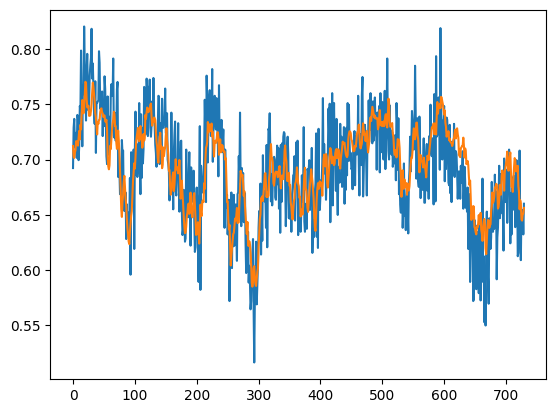

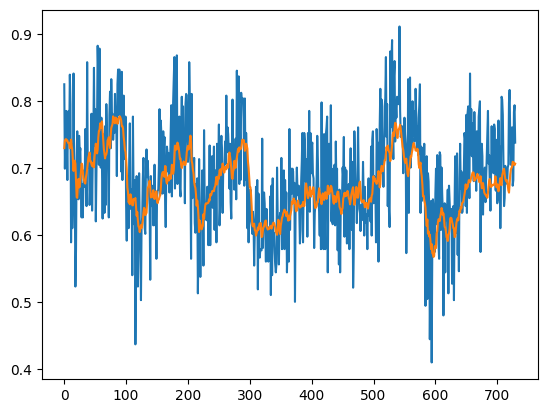

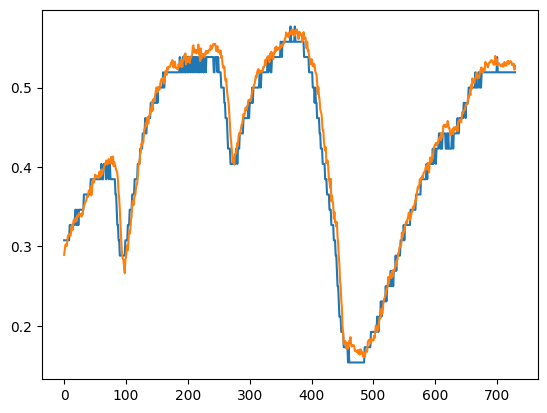

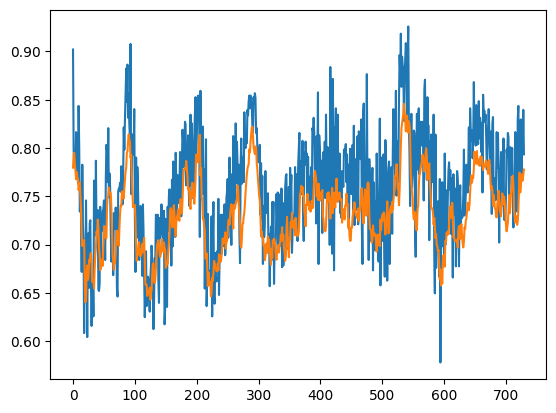

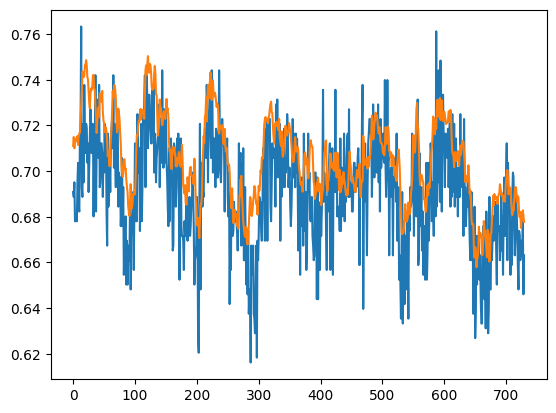

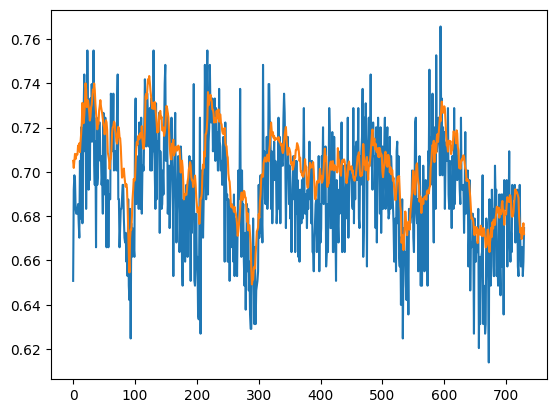

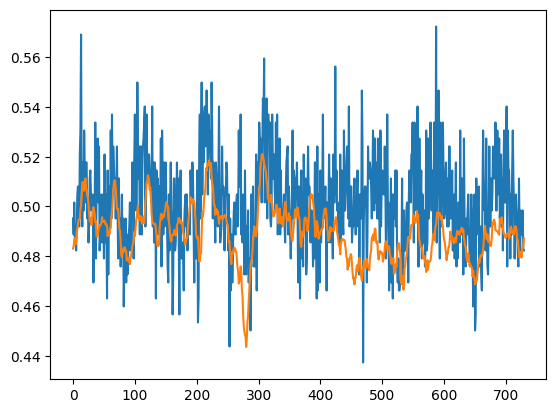

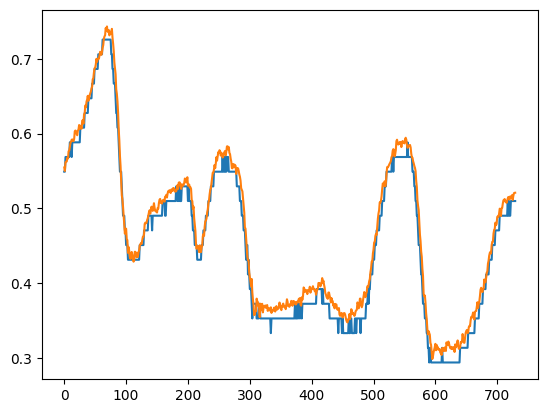

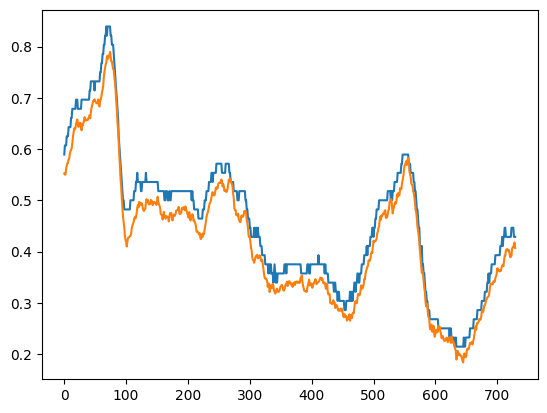

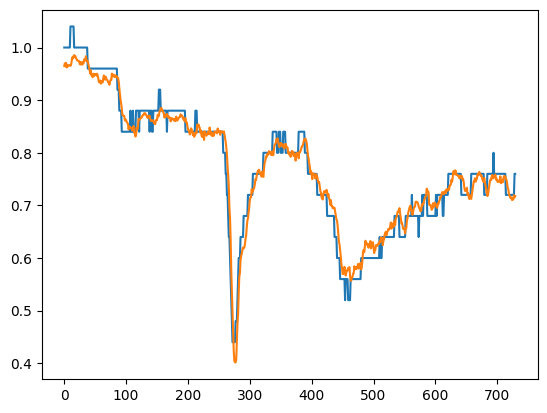

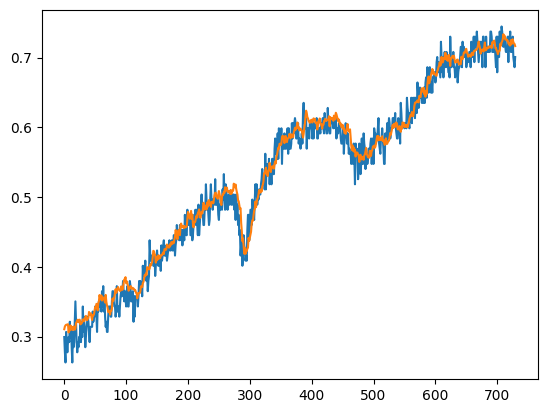

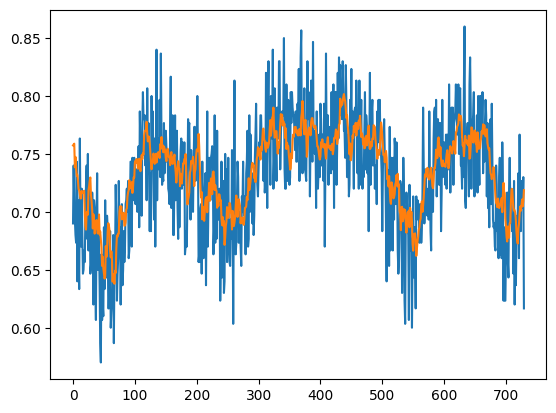

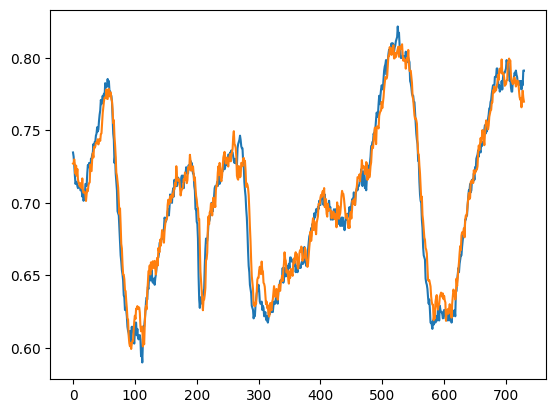

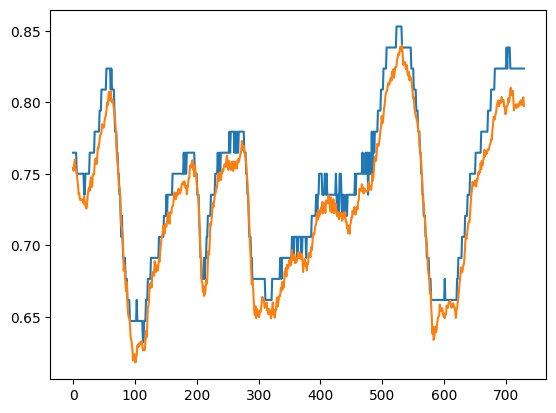

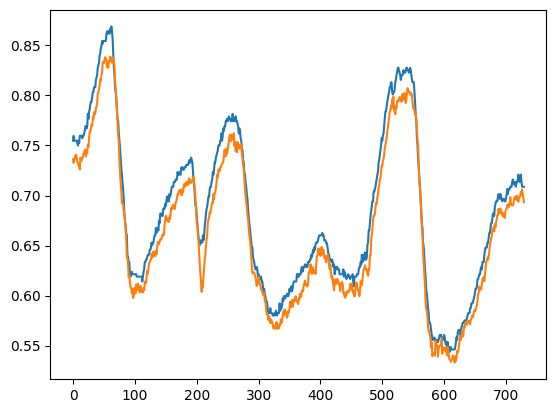

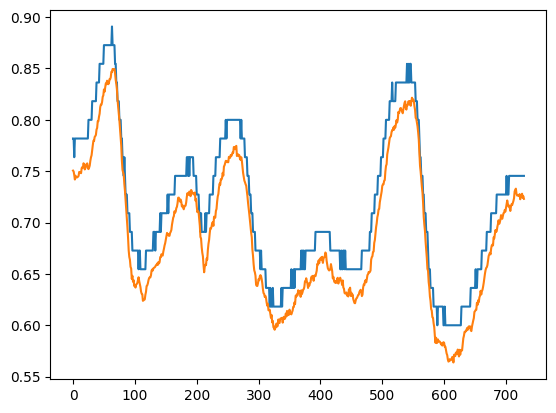

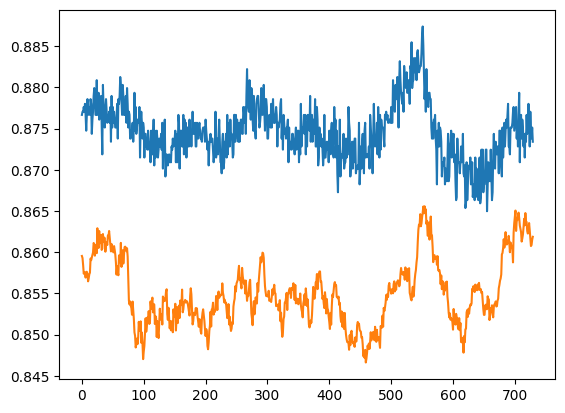

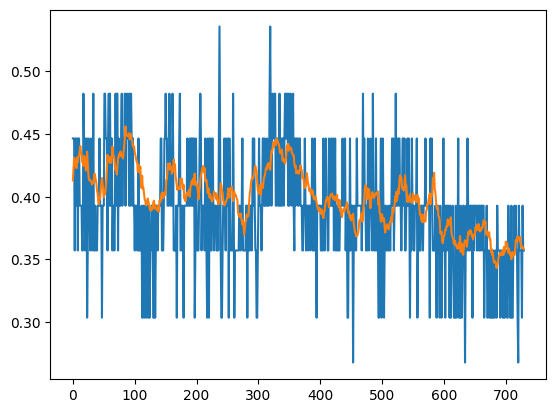

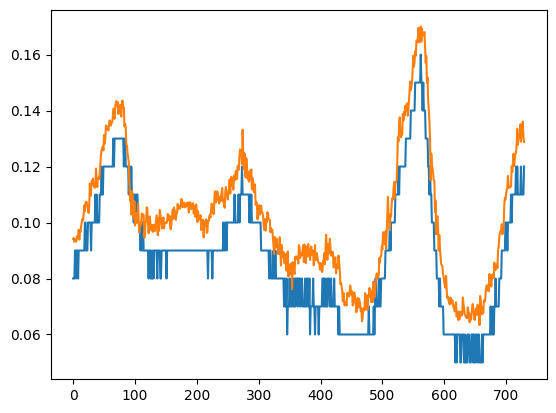

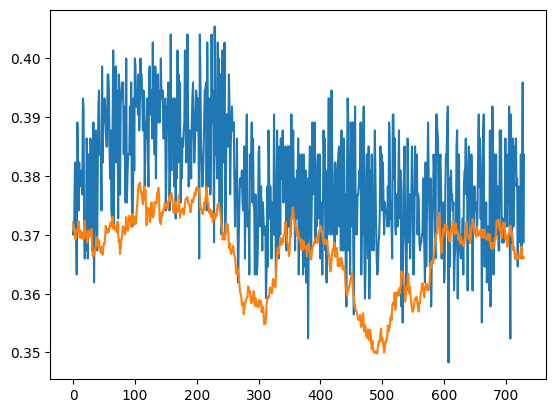

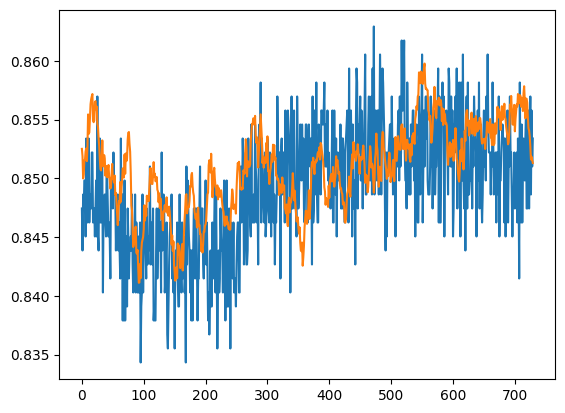

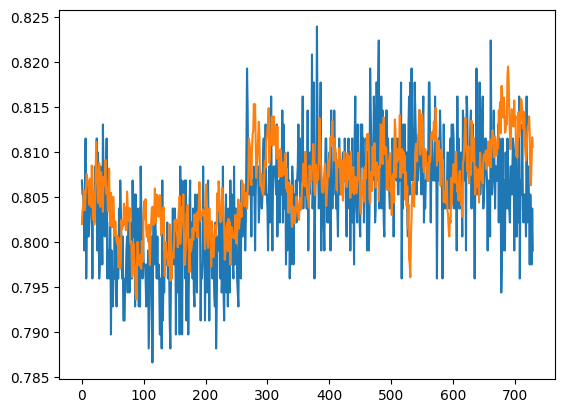

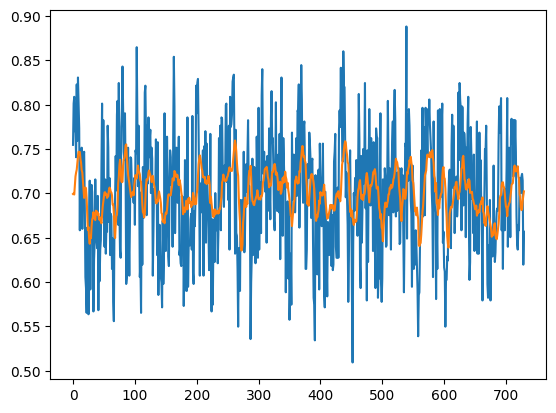

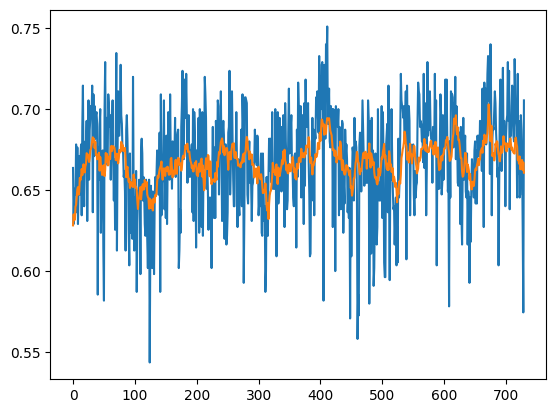

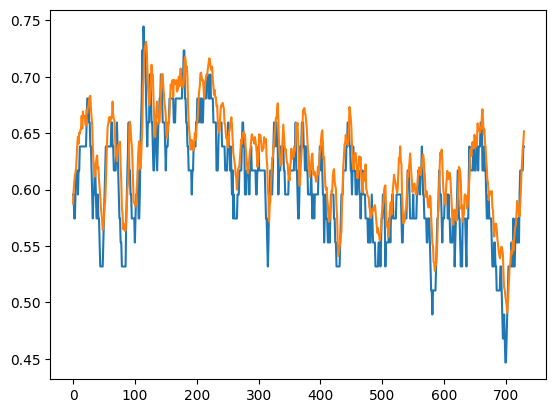

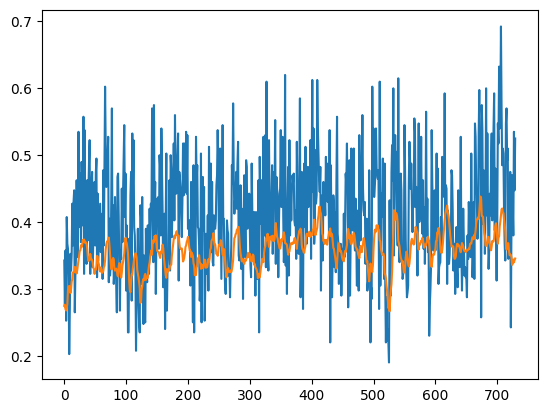

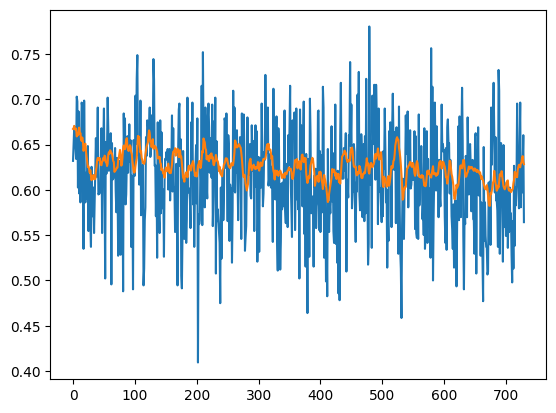

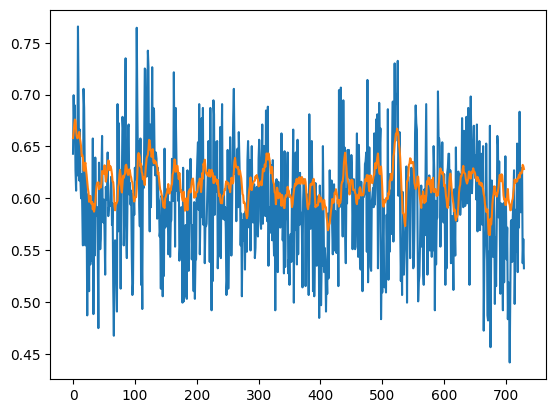

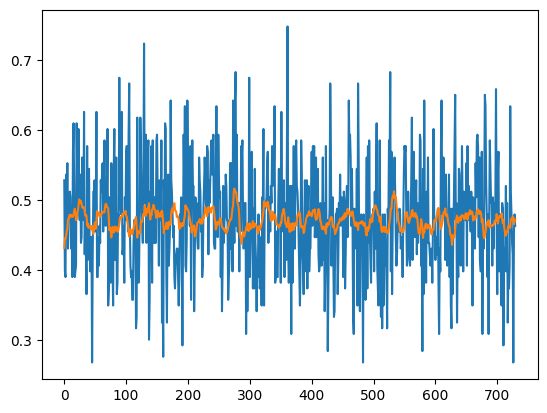

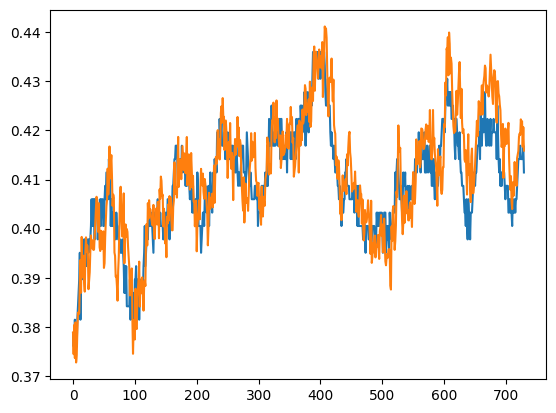

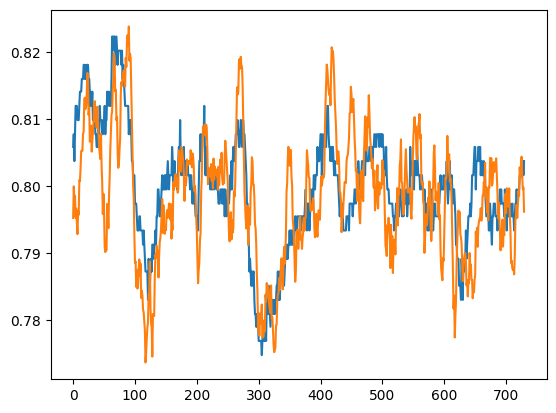

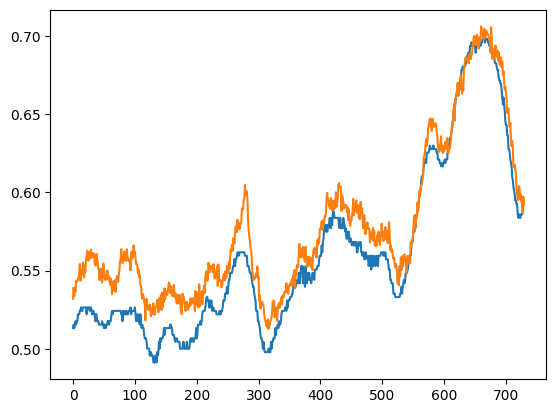

In [61]:
# With 1D Convolution and both GATs
import matplotlib.pyplot as plt

for i in range(window.shape[1]):
    plt.plot(targets[:,i], label="target")
    plt.plot(preds[:,i], label="pred")
    plt.show()

# 5. Eval w/ Global Anomaly

In [62]:
# Global Outlier: Benchmark
test = torch.FloatTensor(test_dfs[3][::dropout].values)
test_anom = np.copy(test)

num_timesteps = test_anom.shape[0]
start = num_timesteps-750

test_anom = test_anom[start:]
test = test[start:]

num_timesteps,_ = test.shape

test_anom[int(num_timesteps*.5):int(num_timesteps*.5+30),1] = test[int(num_timesteps*.5):int(num_timesteps*.5+30),1]*8
test_anom = torch.FloatTensor(test_anom)



In [63]:
# Global Outlier (sinusoidal data)
#test = data[int(timesteps*.8):]
#test_anom = np.copy(test)
#test_anom[int(num_timesteps*.5):int(num_timesteps*.5+30),1] = test[int(num_timesteps*.5):int(num_timesteps*.5+30),1]*8
#test_anom = torch.FloatTensor(test_anom)

In [64]:
test_dataset = TimewindowDataset(test_anom, window_size)
test_dataloader = DataLoader(test_dataset)

In [65]:
#test = torch.FloatTensor(test_dfs[3][::dropout].values)
#test_dataset = TimewindowDataset(test, window_size)
#test_dataloader = DataLoader(test_dataset)

In [66]:
# Eval model without GRU
model.eval()
preds = None
targets_anom = None
attn_f = None
attn_t = None
attn_f_edge_idx = None
attn_t_edge_idx = None

for i,item in enumerate(test_dataloader):
    #if i%100==0:
    print(f"item: {i}/{len(test_dataloader)}")
    window, target = item
    window = window.squeeze()
    target = target.T.squeeze()
    x,alpha_f,alpha_t = model(window)
    '''if i%100 == 0:
        for attn_head in range(alpha_f[1].shape[1]):
            alpha_f_matrix = np.zeros((num_sensors,num_sensors))
            edges = alpha_f[0]
            weights = alpha_f[1][:,attn_head]
            #print(edges)
            #print(weights)
            for idx in range(len(edges[0])):
                i,j = edges[0][idx],edges[1][idx]
                alpha_f_matrix[i][j] = weights[idx]
            print("Alpha Spatial")
            print(alpha_f_matrix)
        for attn_head in range(alpha_t[1].shape[1]):
            max_timestep = alpha_t[0][0].max()+1
            alpha_t_matrix = np.zeros((max_timestep,max_timestep))
            edges = alpha_t[0]
            weights = alpha_t[1][:,attn_head]
            #print(edges)
            #print(weights)
            for idx in range(len(edges[0])):
                i,j = edges[0][idx],edges[1][idx]
                alpha_t_matrix[i][j] = weights[idx]
            print("Alpha Temporal")
            print(alpha_t_matrix)'''
            
    '''if i >= int(num_timesteps*.5) and i <= num_timesteps*.5+30:
        print("##### ANOMALY #####")

        for attn_head in range(alpha_f[1].shape[1]):
            alpha_f_matrix = np.zeros((num_sensors,num_sensors))
            edges = alpha_f[0]
            weights = alpha_f[1][:,attn_head]
            #print(edges)
            #print(weights)
            for idx in range(len(edges[0])):
                i,j = edges[0][idx],edges[1][idx]
                alpha_f_matrix[i][j] = weights[idx]
            print("Alpha ANOMALY Spatial")
            print(alpha_f_matrix)
        for attn_head in range(alpha_t[1].shape[1]):
            max_timestep = alpha_t[0][0].max()+1
            alpha_t_matrix = np.zeros((max_timestep,max_timestep))
            edges = alpha_t[0]
            weights = alpha_t[1][:,attn_head]
            #print(edges)
            #print(weights)
            for idx in range(len(edges[0])):
                i,j = edges[0][idx],edges[1][idx]
                alpha_t_matrix[i][j] = weights[idx]
            print("Alpha ANOMALY Temporal")
            print(alpha_t_matrix)'''
            
    if preds is None:
        preds = x.detach().numpy().reshape(-1)
    else:
        preds = np.vstack((preds,x.detach().numpy().reshape(-1)))
    if targets_anom is None:
        targets_anom = target.detach().numpy().reshape(-1)
    else:
        targets_anom = np.vstack((targets_anom,target.detach().numpy().reshape(-1)))
    # Save spatial attention
    if attn_f is None:
        attn_f = np.expand_dims(alpha_f[1].detach().numpy(),axis=0)
    else:
        attn_f = np.vstack((attn_f,np.expand_dims(alpha_f[1].detach().numpy(),axis=0)))   
    # Save temporal attention
    if attn_t is None:
        attn_t = np.expand_dims(alpha_t[1].detach().numpy(),axis=0)
    else:
        attn_t = np.vstack((attn_t,np.expand_dims(alpha_t[1].detach().numpy(),axis=0)))        
    # Save spatial attention edge index (once)
    if attn_f_edge_idx is None:
        attn_f_edge_idx = alpha_f[0].detach().numpy()
    # Save temporal attention edge index (once)        
    if attn_t_edge_idx is None:
        attn_t_edge_idx = alpha_t[0].detach().numpy()      

item: 0/730
item: 1/730
item: 2/730
item: 3/730
item: 4/730
item: 5/730
item: 6/730
item: 7/730
item: 8/730
item: 9/730
item: 10/730
item: 11/730
item: 12/730
item: 13/730
item: 14/730
item: 15/730
item: 16/730
item: 17/730
item: 18/730
item: 19/730
item: 20/730
item: 21/730
item: 22/730
item: 23/730
item: 24/730
item: 25/730
item: 26/730
item: 27/730
item: 28/730
item: 29/730
item: 30/730
item: 31/730
item: 32/730
item: 33/730
item: 34/730
item: 35/730
item: 36/730
item: 37/730
item: 38/730
item: 39/730
item: 40/730
item: 41/730
item: 42/730
item: 43/730
item: 44/730
item: 45/730
item: 46/730
item: 47/730
item: 48/730
item: 49/730
item: 50/730
item: 51/730
item: 52/730
item: 53/730
item: 54/730
item: 55/730
item: 56/730
item: 57/730
item: 58/730
item: 59/730
item: 60/730
item: 61/730
item: 62/730
item: 63/730
item: 64/730
item: 65/730
item: 66/730
item: 67/730
item: 68/730
item: 69/730
item: 70/730
item: 71/730
item: 72/730
item: 73/730
item: 74/730
item: 75/730
item: 76/730
item: 77/

item: 632/730
item: 633/730
item: 634/730
item: 635/730
item: 636/730
item: 637/730
item: 638/730
item: 639/730
item: 640/730
item: 641/730
item: 642/730
item: 643/730
item: 644/730
item: 645/730
item: 646/730
item: 647/730
item: 648/730
item: 649/730
item: 650/730
item: 651/730
item: 652/730
item: 653/730
item: 654/730
item: 655/730
item: 656/730
item: 657/730
item: 658/730
item: 659/730
item: 660/730
item: 661/730
item: 662/730
item: 663/730
item: 664/730
item: 665/730
item: 666/730
item: 667/730
item: 668/730
item: 669/730
item: 670/730
item: 671/730
item: 672/730
item: 673/730
item: 674/730
item: 675/730
item: 676/730
item: 677/730
item: 678/730
item: 679/730
item: 680/730
item: 681/730
item: 682/730
item: 683/730
item: 684/730
item: 685/730
item: 686/730
item: 687/730
item: 688/730
item: 689/730
item: 690/730
item: 691/730
item: 692/730
item: 693/730
item: 694/730
item: 695/730
item: 696/730
item: 697/730
item: 698/730
item: 699/730
item: 700/730
item: 701/730
item: 702/730
item: 

In [67]:
# Save items
np.save("gat_artifacts/targets_global_anom.npy", targets_anom)
np.save("gat_artifacts/preds_global_anom.npy", preds)
np.save("gat_artifacts/attn_f_global_anom.npy", attn_f)
np.save("gat_artifacts/attn_t_global_anom.npy", attn_t)
np.save("gat_artifacts/attn_f_edge_idx_global_anom.npy", attn_f_edge_idx)
np.save("gat_artifacts/attn_t_edge_idx_global_anom.npy", attn_t_edge_idx)


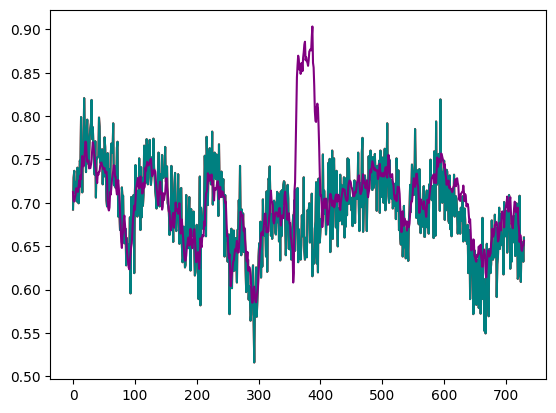

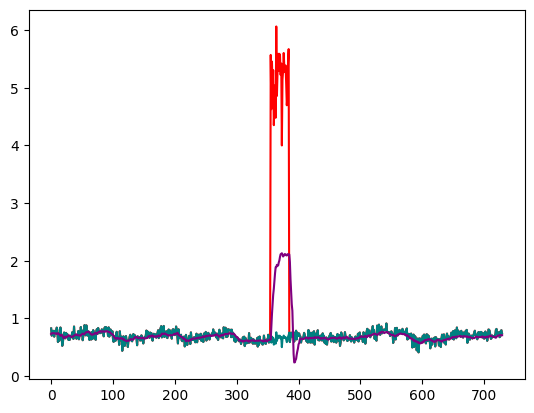

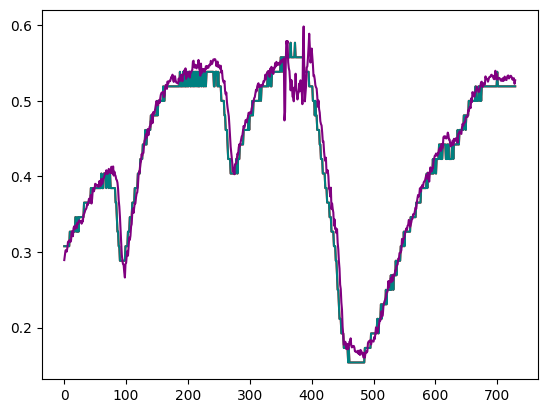

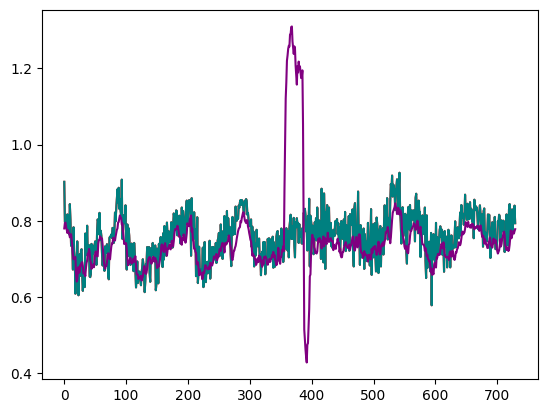

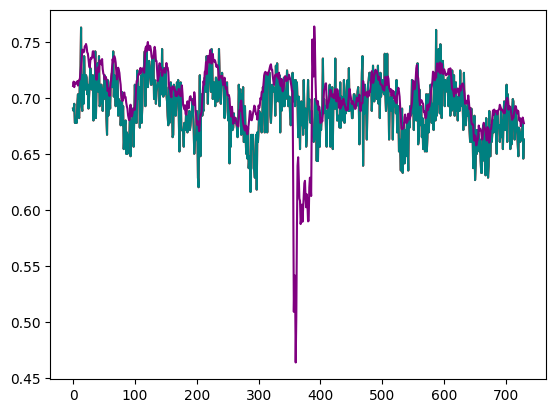

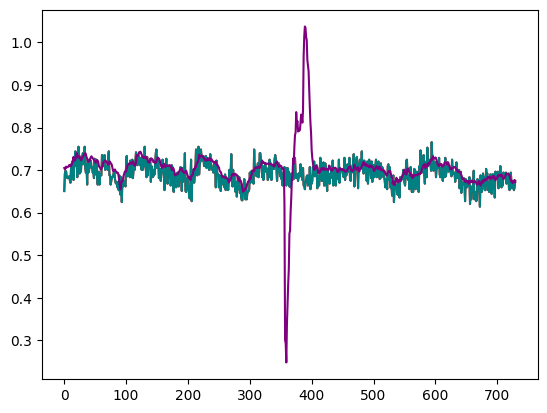

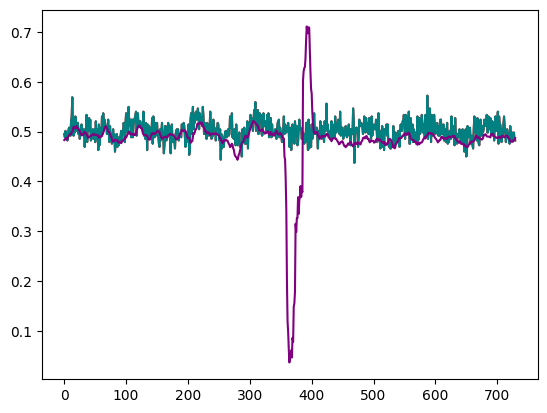

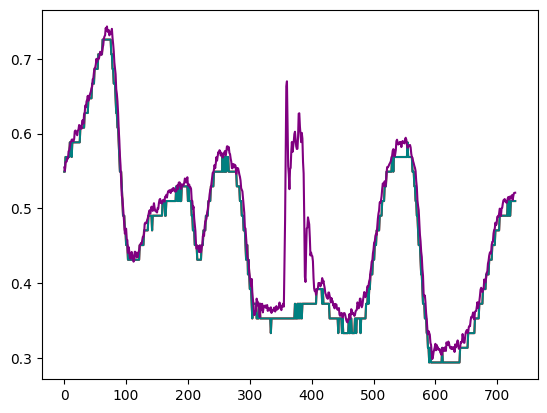

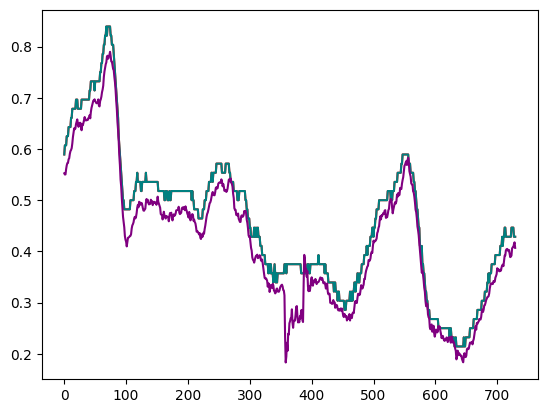

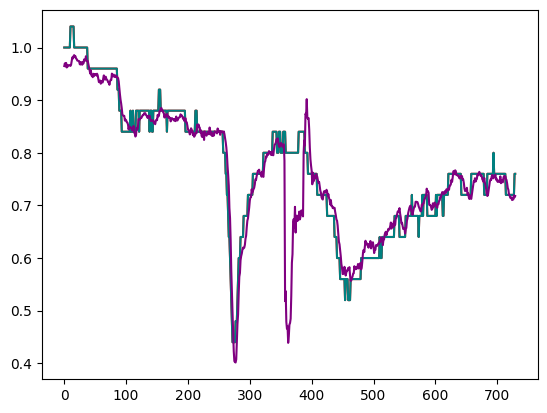

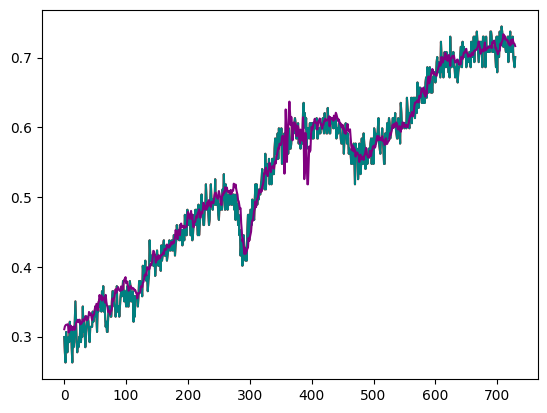

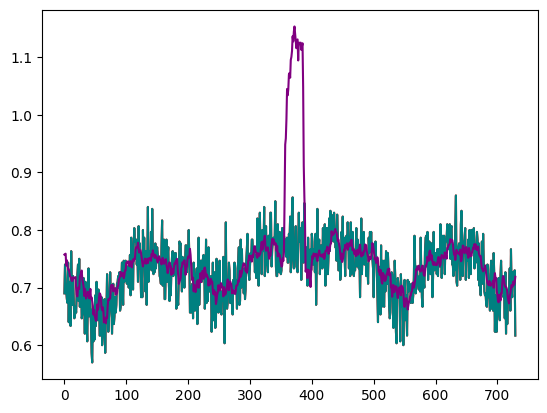

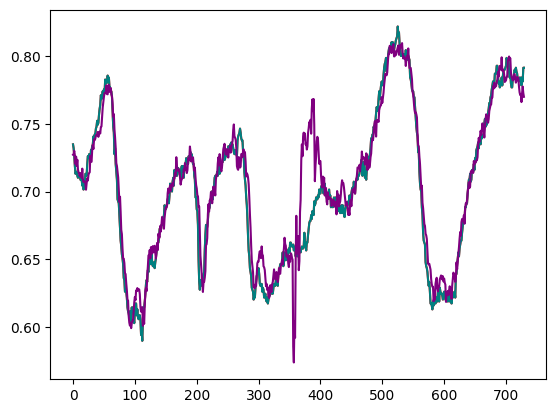

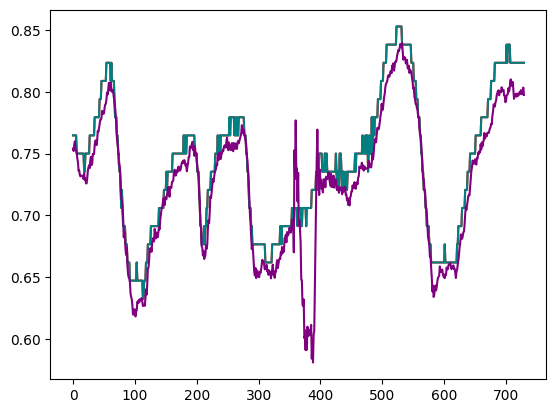

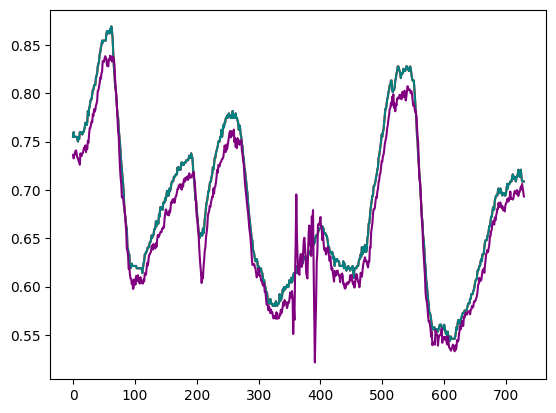

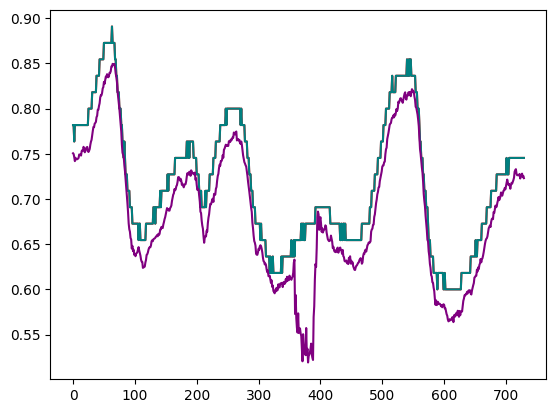

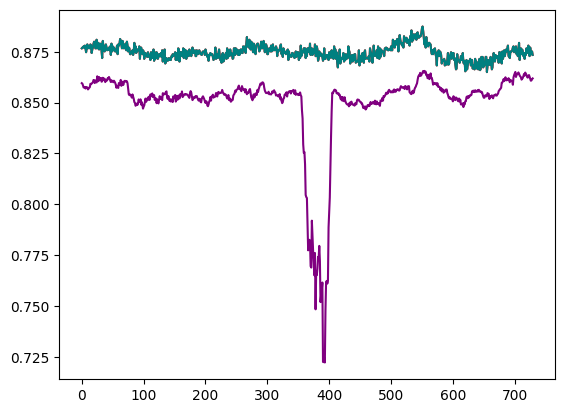

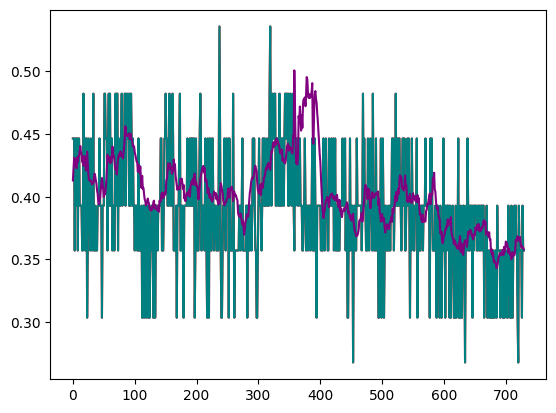

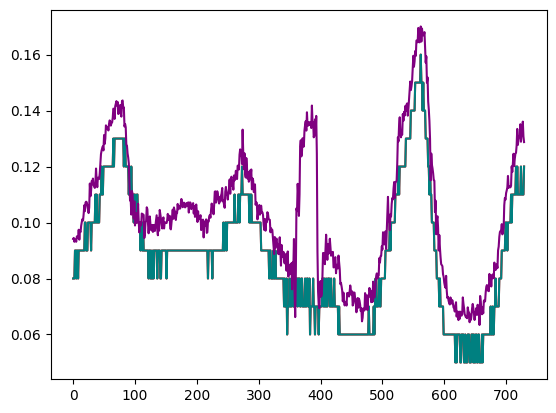

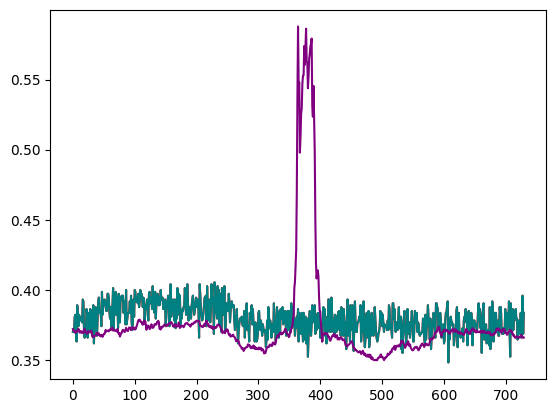

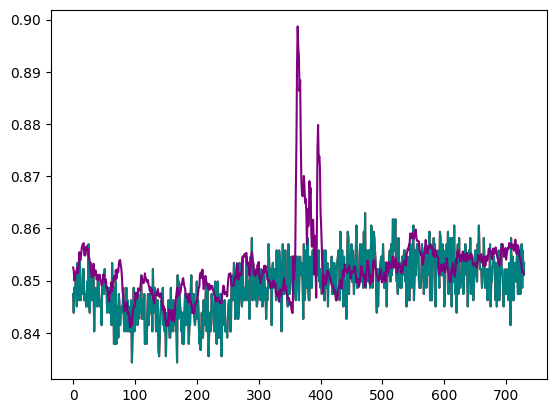

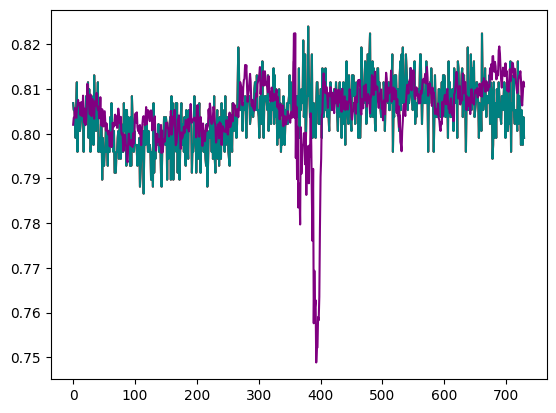

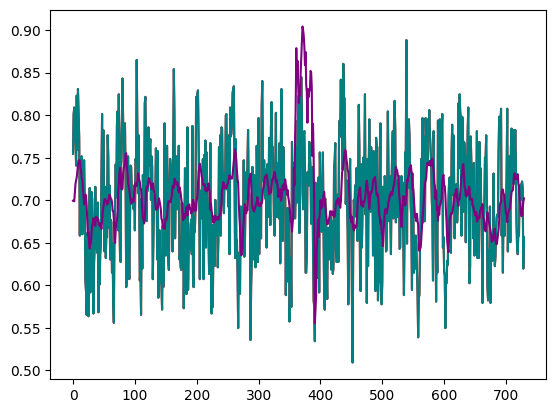

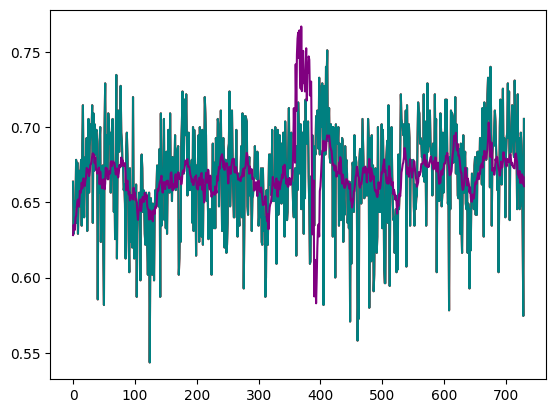

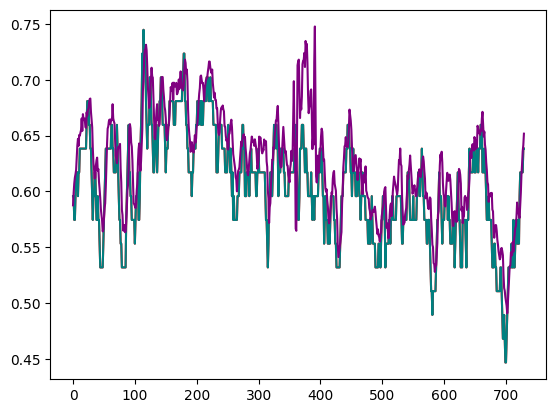

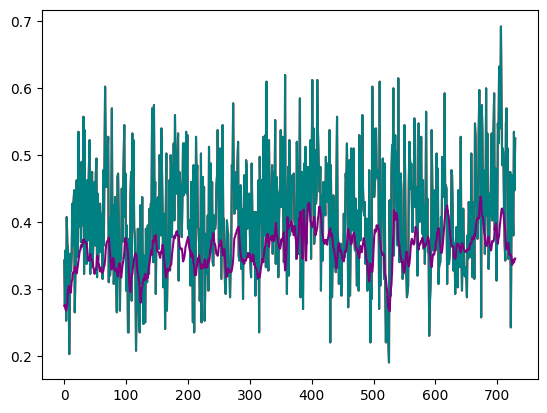

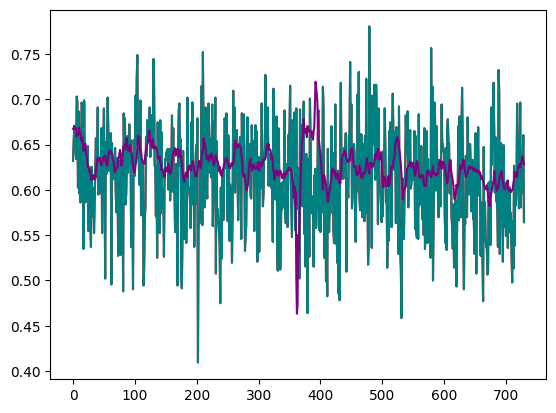

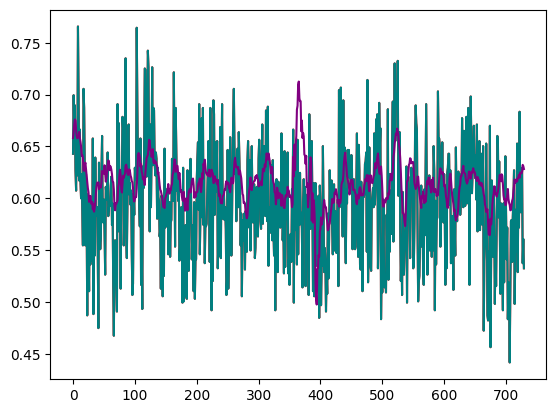

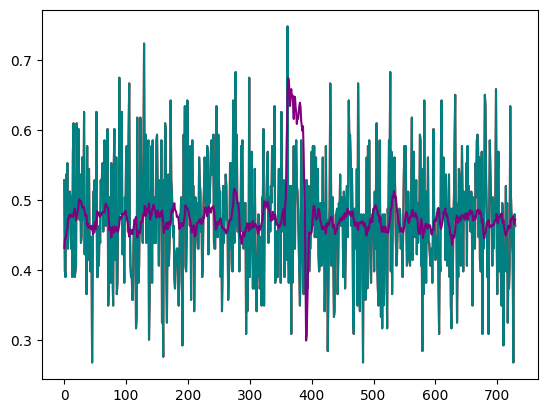

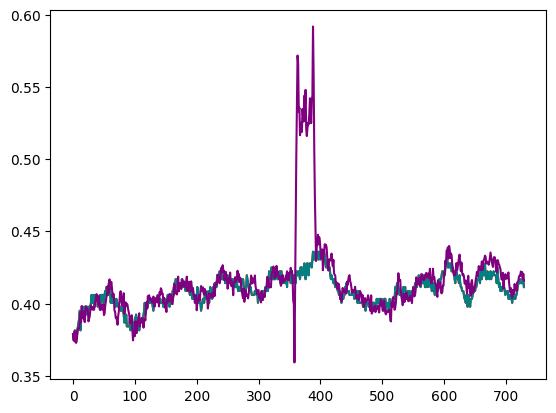

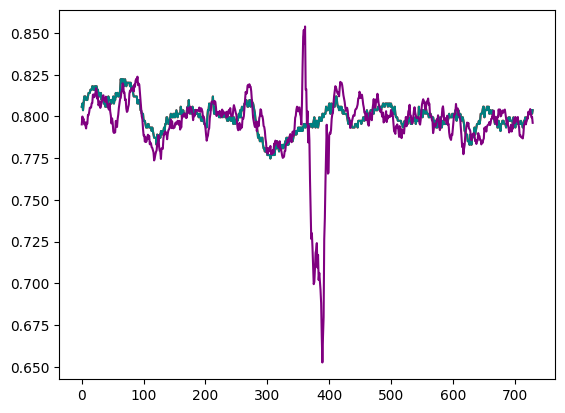

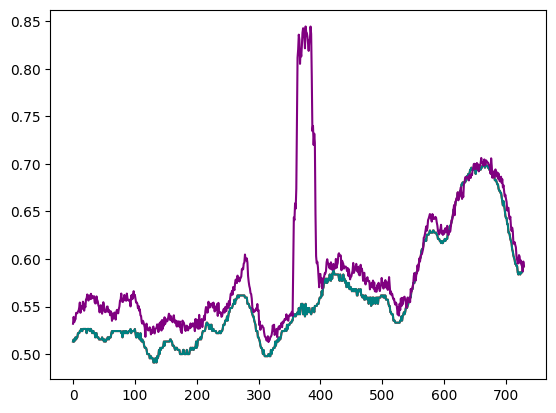

In [68]:
# With 1D Convolution and both GATs
import matplotlib.pyplot as plt

for i in range(window.shape[1]):
    plt.plot(targets_anom[:,i], label="target_anom", c="red")
    plt.plot(targets[:,i], label="target",c="teal")
    plt.plot(preds[:,i], label="pred", c="purple")
    plt.show()

# 6. Eval w/ Trend Anomaly

In [69]:
# Trend Outlier: Benchmark

test = torch.FloatTensor(test_dfs[3][::dropout].values)
test_anom = np.copy(test)

num_timesteps = test_anom.shape[0]
start = num_timesteps-750

test_anom = test_anom[start:]
test = test[start:]

num_timesteps,_ = test.shape

test_anom[int(num_timesteps*.5):,0] = test[int(num_timesteps*.5):,0]+0.1+np.linspace(0,test[int(num_timesteps*.5):,0].max(),len(test[int(num_timesteps*.5):,0]))
test_anom = torch.FloatTensor(test_anom)



In [70]:
# Trend Outlier: Sinusoidal Data
#test = data[int(timesteps*.8):]
#test_anom = np.copy(test)
#test_anom[int(num_timesteps*.5):,0] = test[int(num_timesteps*.5):,0]+0.1+np.linspace(0,test[int(num_timesteps*.5):,0].max(),len(test[int(num_timesteps*.5):,0]))
#test_anom = torch.FloatTensor(test_anom)

In [71]:
test_anom_dataset = TimewindowDataset(test_anom, window_size)
test_anom_dataloader = DataLoader(test_anom_dataset)

In [72]:
#test = torch.FloatTensor(test_dfs[3][::dropout].values)
#test_dataset = TimewindowDataset(test, window_size)
#test_dataloader = DataLoader(test_dataset)

In [73]:
# Eval model without GRU
model.eval()
preds = None
targets_anom = None
attn_f = None
attn_t = None
attn_f_edge_idx = None
attn_t_edge_idx = None

for i,item in enumerate(test_anom_dataloader):
    if i%100==0:
        print(f"item: {i}/{len(test_dataloader)}")
    window, target = item
    window = window.squeeze()
    target = target.T.squeeze()
    
    x,alpha_f,alpha_t = model(window)
    '''if i%100 == 0:
        if i >= int(num_timesteps*.5):
            print("*** ANOMALY ***")
        for attn_head in range(alpha_f[1].shape[1]):
            alpha_f_matrix = np.zeros((num_sensors,num_sensors))
            edges = alpha_f[0]
            weights = alpha_f[1][:,attn_head]
            #print(edges)
            #print(weights)
            for idx in range(len(edges[0])):
                i,j = edges[0][idx],edges[1][idx]
                alpha_f_matrix[i][j] = weights[idx]
            print("Alpha Spatial")
            print(alpha_f_matrix)
        for attn_head in range(alpha_t[1].shape[1]):
            max_timestep = alpha_t[0][0].max()+1
            alpha_t_matrix = np.zeros((max_timestep,max_timestep))
            edges = alpha_t[0]
            weights = alpha_t[1][:,attn_head]
            #print(edges)
            #print(weights)
            for idx in range(len(edges[0])):
                i,j = edges[0][idx],edges[1][idx]
                alpha_t_matrix[i][j] = weights[idx]
            print("Alpha Temporal")
            print(alpha_t_matrix)'''
            
    if preds is None:
        preds = x.detach().numpy().reshape(-1)
    else:
        preds = np.vstack((preds,x.detach().numpy().reshape(-1)))
    if targets_anom is None:
        targets_anom = target.detach().numpy().reshape(-1)
    else:
        targets_anom = np.vstack((targets_anom,target.detach().numpy().reshape(-1)))
    # Save spatial attention
    if attn_f is None:
        attn_f = np.expand_dims(alpha_f[1].detach().numpy(),axis=0)
    else:
        attn_f = np.vstack((attn_f,np.expand_dims(alpha_f[1].detach().numpy(),axis=0)))   
    # Save temporal attention
    if attn_t is None:
        attn_t = np.expand_dims(alpha_t[1].detach().numpy(),axis=0)
    else:
        attn_t = np.vstack((attn_t,np.expand_dims(alpha_t[1].detach().numpy(),axis=0)))        
    # Save spatial attention edge index (once)
    if attn_f_edge_idx is None:
        attn_f_edge_idx = alpha_f[0].detach().numpy()
    # Save temporal attention edge index (once)        
    if attn_t_edge_idx is None:
        attn_t_edge_idx = alpha_t[0].detach().numpy()      

item: 0/730
item: 100/730
item: 200/730
item: 300/730
item: 400/730
item: 500/730
item: 600/730
item: 700/730


In [74]:
# Save items
np.save("gat_artifacts/targets_trend_anom.npy", targets_anom)
np.save("gat_artifacts/preds_trend_anom.npy", preds)
np.save("gat_artifacts/attn_f_trend_anom.npy", attn_f)
np.save("gat_artifacts/attn_t_trend_anom.npy", attn_t)
np.save("gat_artifacts/attn_f_edge_idx_trend_anom.npy", attn_f_edge_idx)
np.save("gat_artifacts/attn_t_edge_idx_trend_anom.npy", attn_t_edge_idx)


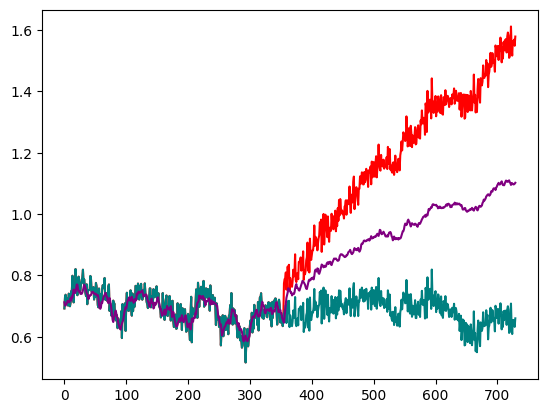

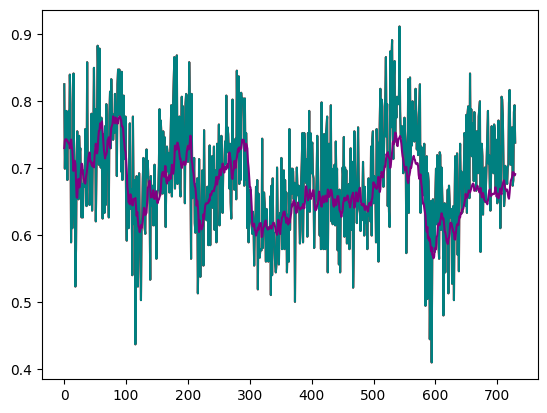

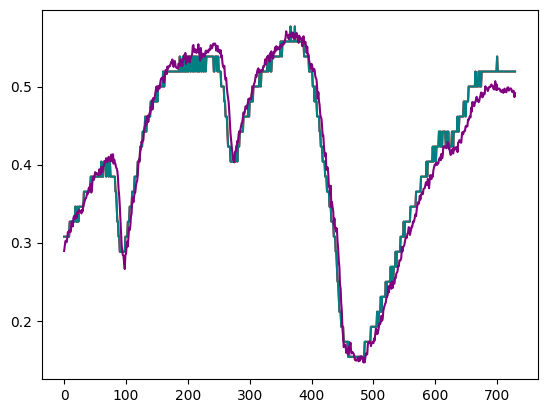

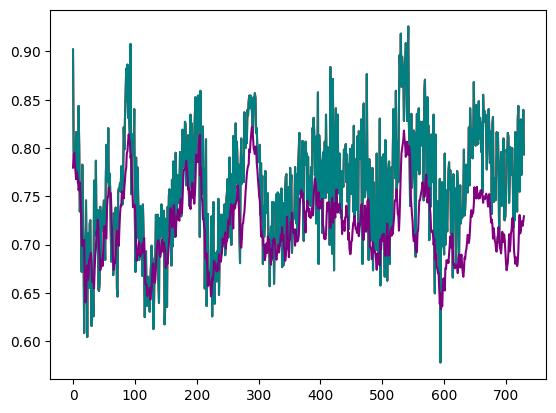

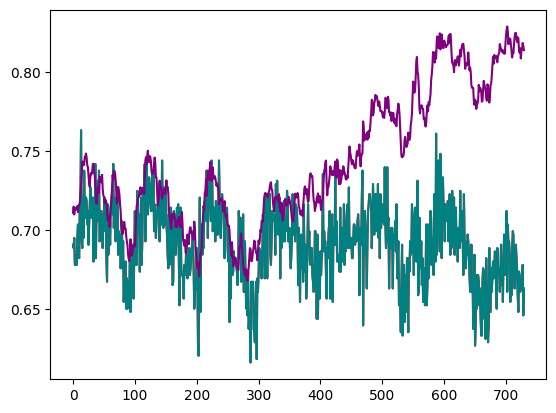

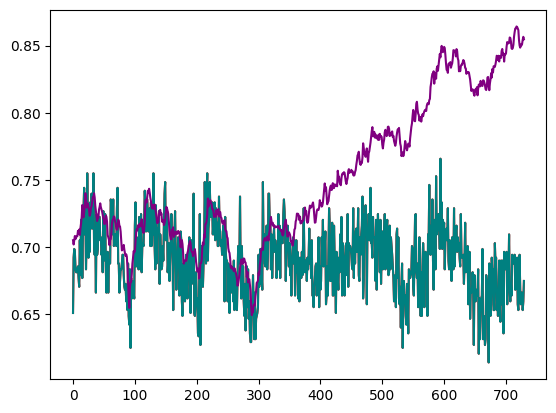

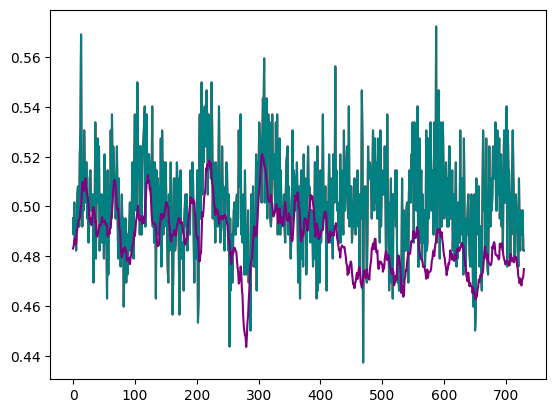

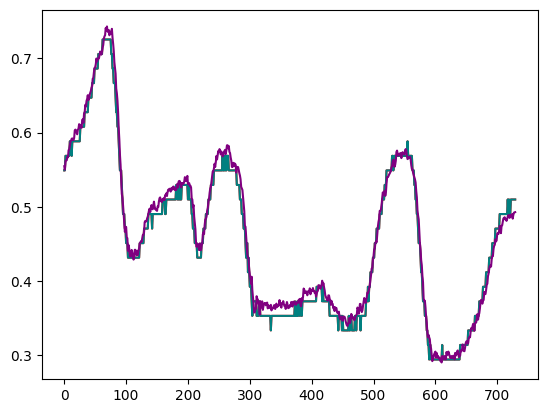

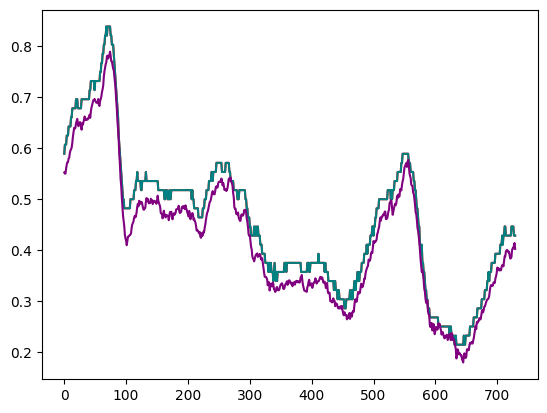

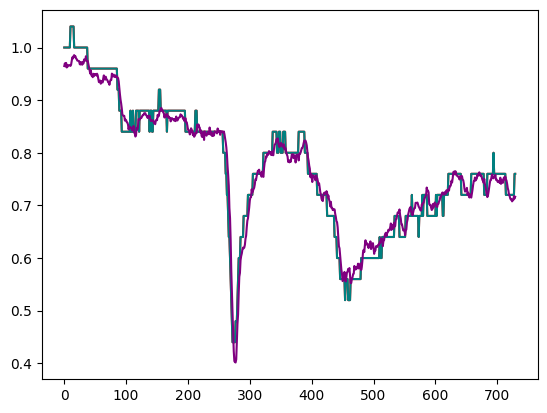

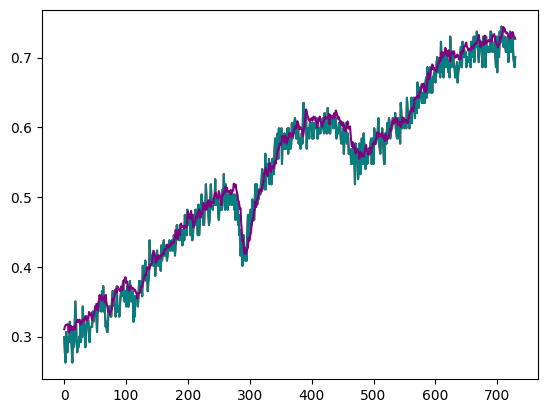

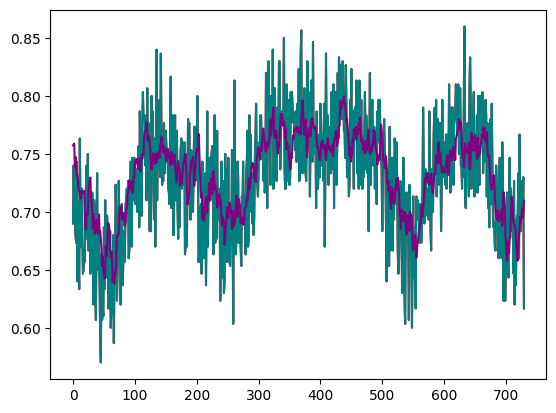

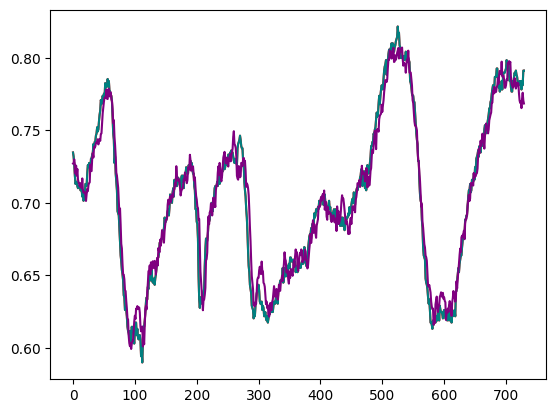

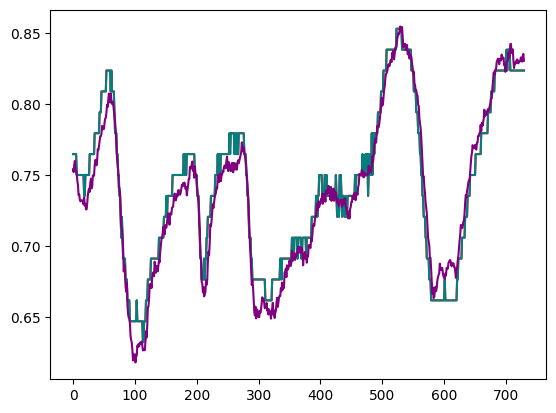

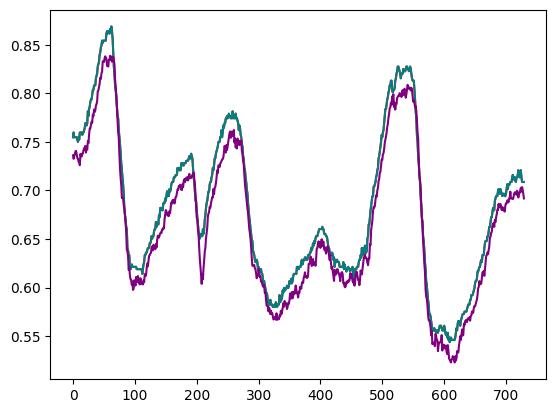

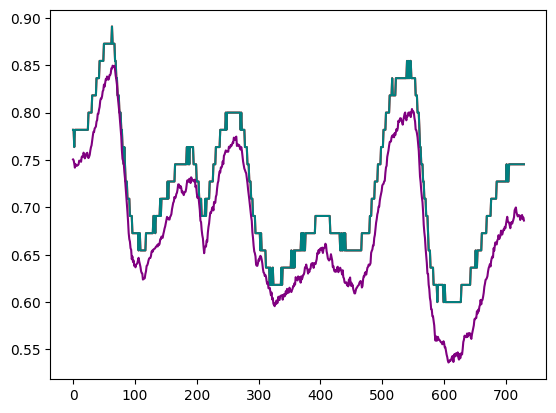

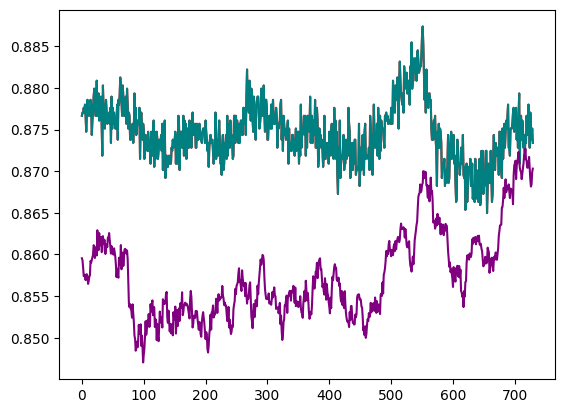

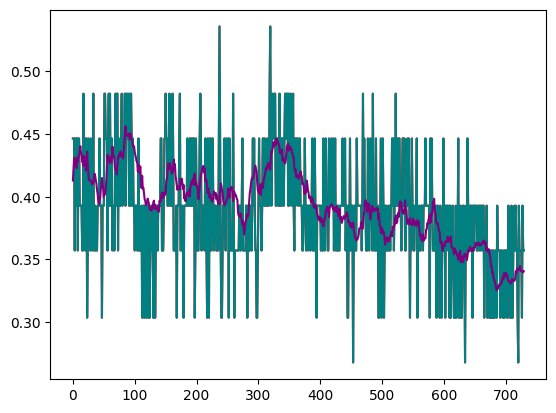

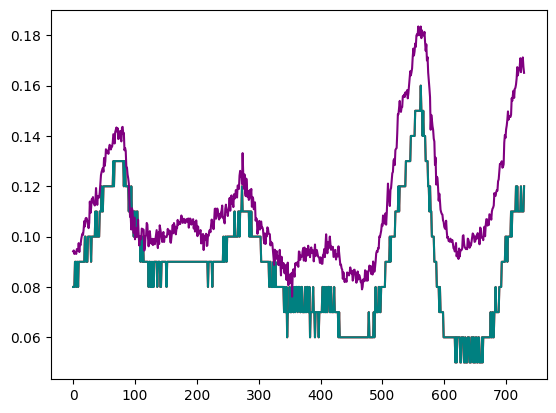

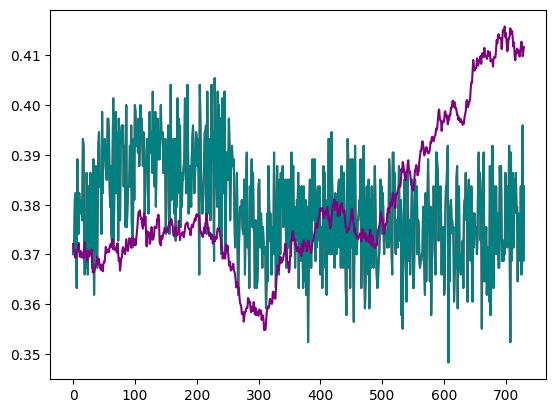

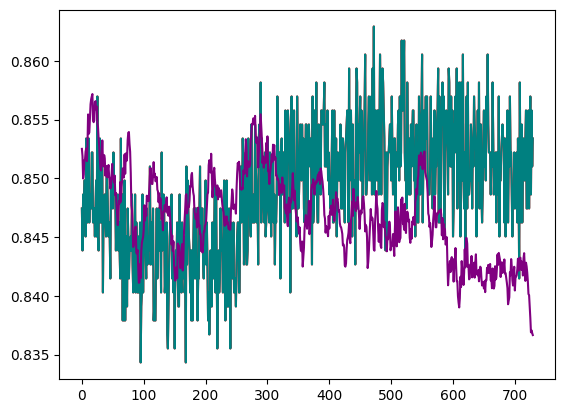

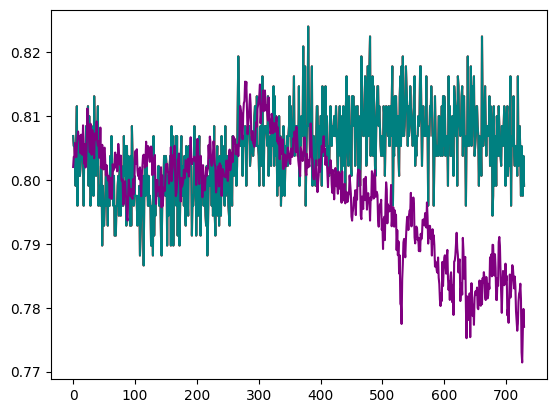

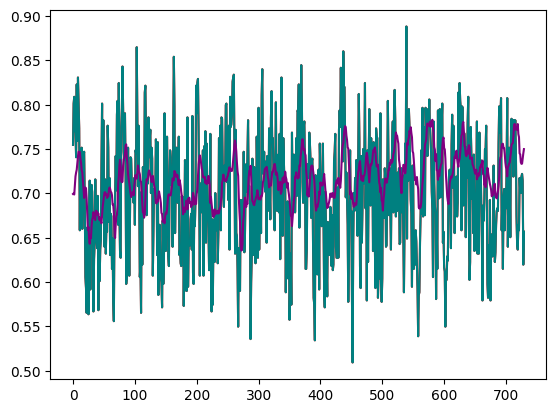

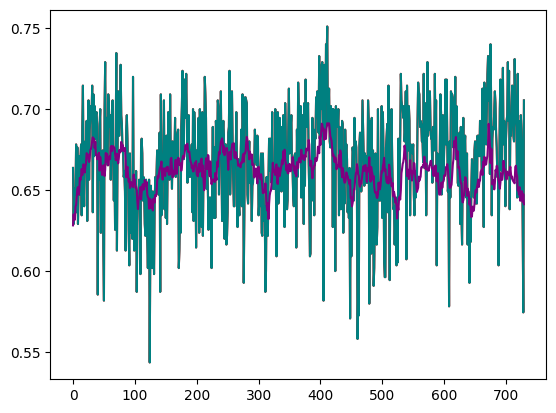

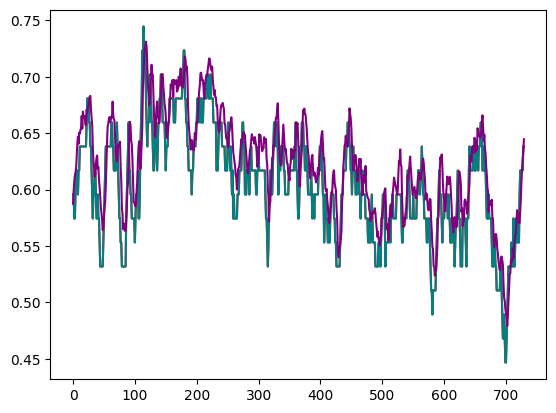

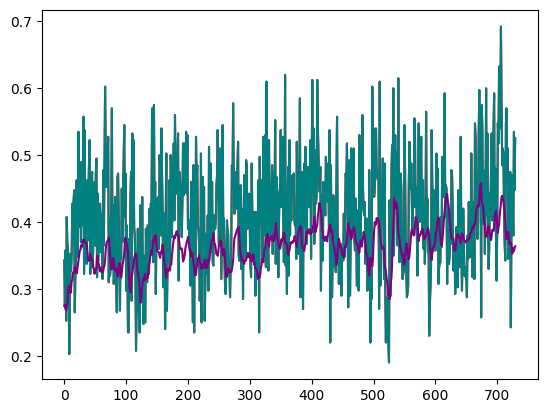

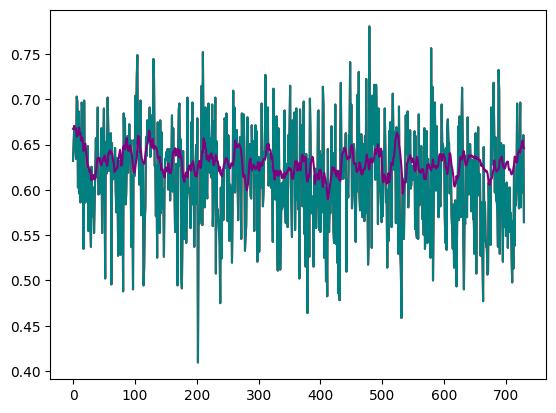

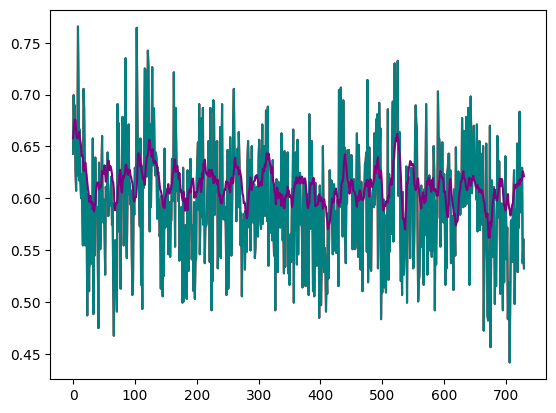

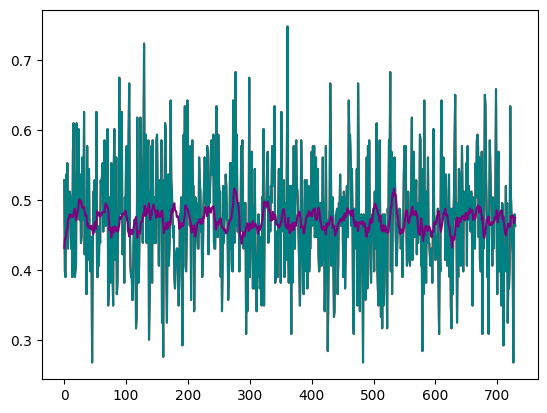

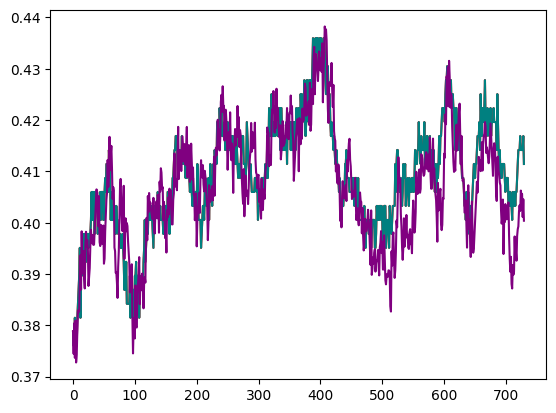

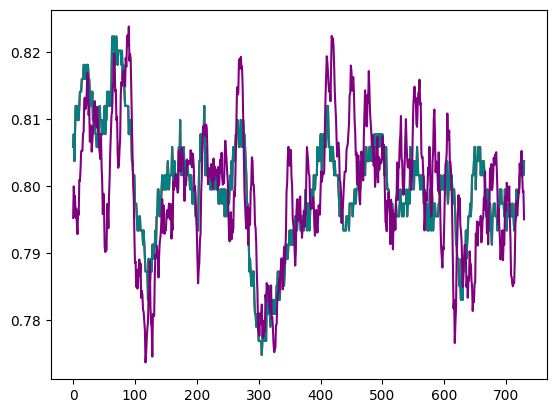

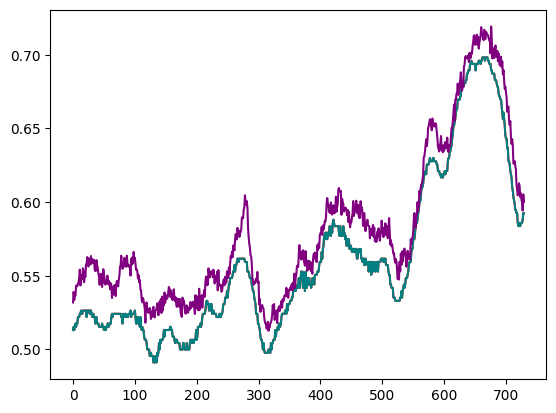

In [75]:
# With 1D Convolution and both GATs
import matplotlib.pyplot as plt

for i in range(window.shape[1]):
    plt.plot(targets_anom[:,i], label="target_anom", c="red")
    plt.plot(targets[:,i], label="target",c="teal")
    plt.plot(preds[:,i], label="pred", c="purple")
    plt.show()

## TODO:
1. ~~Save data (pred, infer, infer_anom, alpha_f, alpha_t)~~
2. ~~Look into time series plot (the pred, infer, infer_anom)~~
3. Look into dynamic graph visualization with weighted edges (pass in timestep)
    - Vary node size based on attention weight
    - Look into selecting attn head as drop down as well
4. Look into slider control to show highlighted square box on time series plot and select data for graph visualization